# Illustration of the convolutional neural network's performance for a multiclass classification task using the dataset with digits from 0 to 9 and a comparison of the results with feedforward neural network

In [1]:
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch

from vladk_neural_network.model.activation import LeakyRelu, Linear
from vladk_neural_network.model.base import NeuralNetwork
from vladk_neural_network.model.layer import (
    Convolutional,
    Flatten,
    FullyConnected,
    Input,
    Input3D,
    MaxPool2D,
)
from vladk_neural_network.model.loss import CategoricalCrossEntropy
from vladk_neural_network.model.metric import AccuracyOneHot
from vladk_neural_network.model.optimizer import Adam

## Helper functions for displaying changes in loss and Accuracy with the change of epochs

In [2]:
def plot_loss(epoch, train_loss, test_loss, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_loss, color='r', label='Train')
    plt.plot(epoch, test_loss, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_accuracy_score(epoch, train_metric, test_metric, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_metric, color='r', label='Train')
    plt.plot(epoch, test_metric, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

## Function to display selected digit

In [3]:
def plot_digit(image, digit):
    if torch.is_tensor(image):
        image = image.numpy().reshape(28, 28)
    else:
        image = torch.tensor(image).numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted digit: {digit}")
    plt.axis("off")
    plt.show()

    return

## Function to display selected digit from cnn dataset 

In [4]:
def plot_digit_cnn(image, digit):
    if torch.is_tensor(image):
        image = image.numpy()
    else:
        image = torch.tensor(image).numpy()
    plt.figure()
    plt.title(f"Predicted digit: {digit}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

    return

## Helper function to get one-hot array for digit

In [5]:
def get_digit(onehot_array):
    for index, value in enumerate(onehot_array):
        if value == 1.0:
            return index
    return None

## Helper function to get digit by one-hot arrary

In [6]:
def get_onehot_digit(digit):
    output = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return output[-digit:] + output[:-digit]

# 1. Classification on digits dataset using simple NN

## Function to get digits train/test data

In [7]:
def get_digits_data():

    dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=10000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        dataset.append(
            {
                "input": torch.tensor(input_values),
                "output": torch.tensor(get_onehot_digit(int(train.loc[index]["label"]))),
            }
        )

    random.seed(123)
    random.shuffle(dataset)
    return dataset[:4000], dataset[4000:5000]

## Create simple NN model for classification on digits dataset and test

Epoch: 1/15, train loss: 0.7482, train Accuracy: 0.7728, test loss: 0.3378, test Accuracy: 0.898, epoch time: 3.293s
Epoch: 2/15, train loss: 0.2389, train Accuracy: 0.925, test loss: 0.332, test Accuracy: 0.902, epoch time: 3.48s
Epoch: 3/15, train loss: 0.1426, train Accuracy: 0.9513, test loss: 0.2371, test Accuracy: 0.937, epoch time: 3.287s
Epoch: 4/15, train loss: 0.0537, train Accuracy: 0.9855, test loss: 0.4327, test Accuracy: 0.903, epoch time: 3.279s
Epoch: 5/15, train loss: 0.0721, train Accuracy: 0.9792, test loss: 0.2775, test Accuracy: 0.928, epoch time: 3.192s
Epoch: 6/15, train loss: 0.0407, train Accuracy: 0.9892, test loss: 0.2724, test Accuracy: 0.93, epoch time: 3.242s
Epoch: 7/15, train loss: 0.0068, train Accuracy: 0.9992, test loss: 0.2361, test Accuracy: 0.95, epoch time: 3.297s
Epoch: 8/15, train loss: 0.0018, train Accuracy: 1.0, test loss: 0.2522, test Accuracy: 0.942, epoch time: 3.208s
Epoch: 9/15, train loss: 0.0009, train Accuracy: 1.0, test loss: 0.2516,

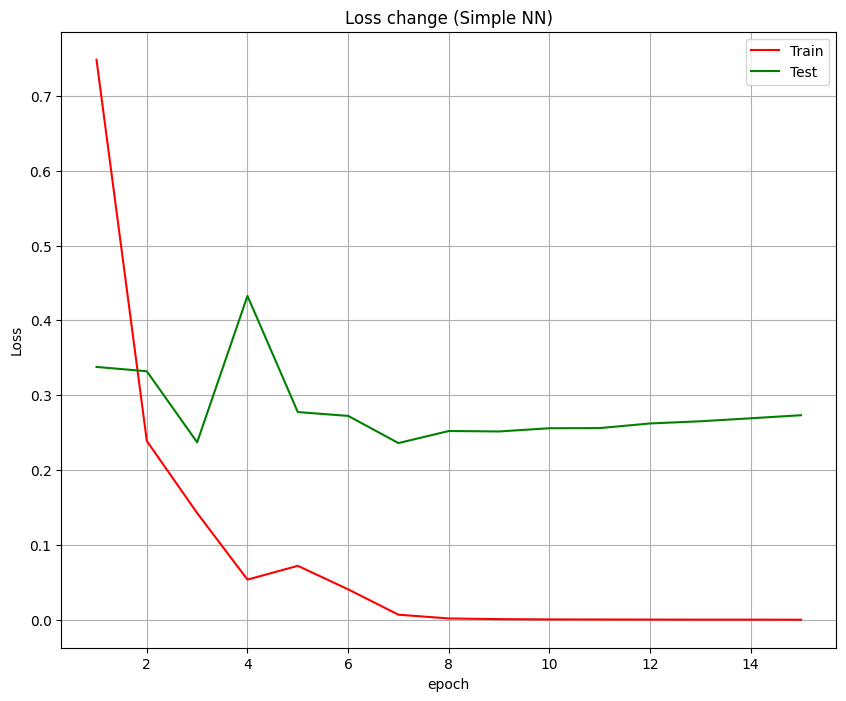

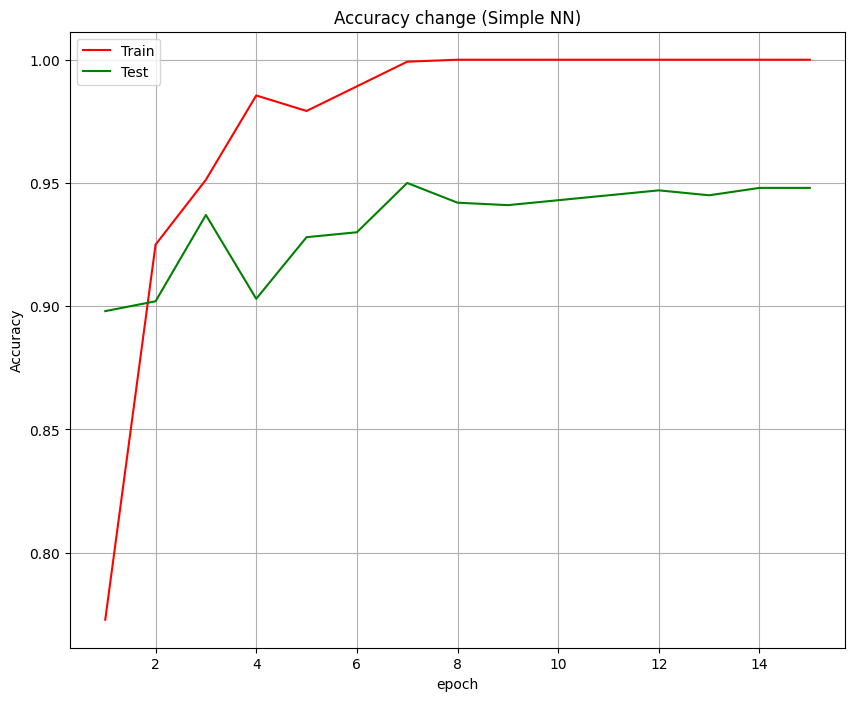

In [8]:
train_dataset, test_dataset = get_digits_data()

layers = [
    FullyConnected(512, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(32, LeakyRelu()),
    FullyConnected(10, Linear()),
]
nn = NeuralNetwork(
    Input(784),
    layers,
    optimizer=Adam(learning_rate=0.0005),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction="argmax"
)

start_time = time.time()

epochs = 15
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=8, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = nn.predict(test_dataset)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change (Simple NN)")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change (Simple NN)")

## First ten test digits with predicted values (Simple NN)

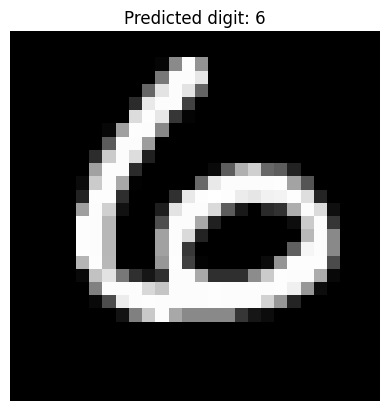

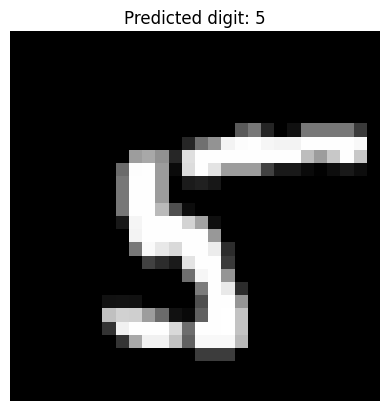

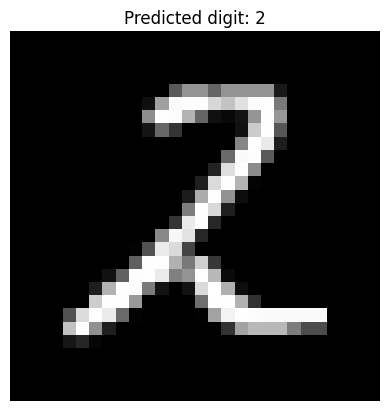

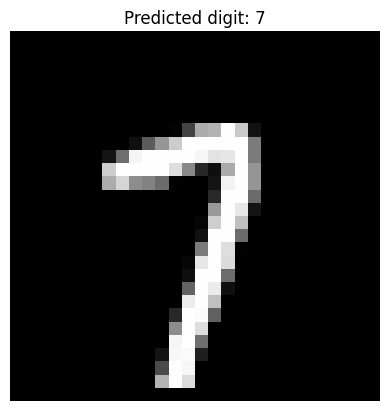

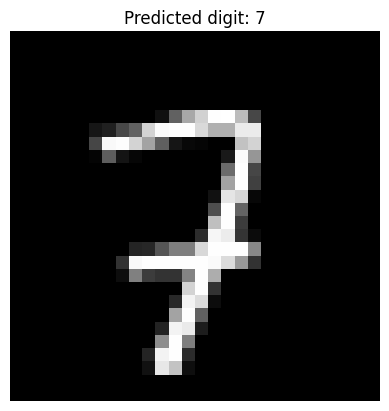

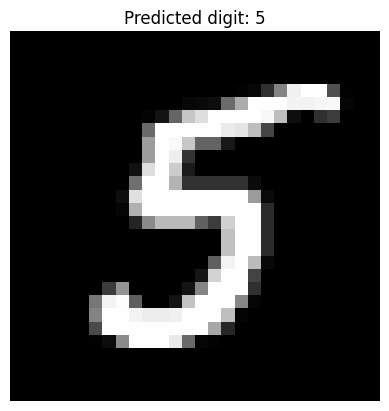

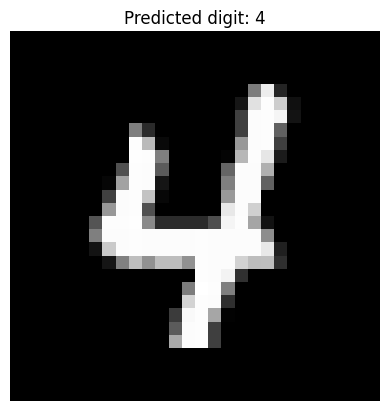

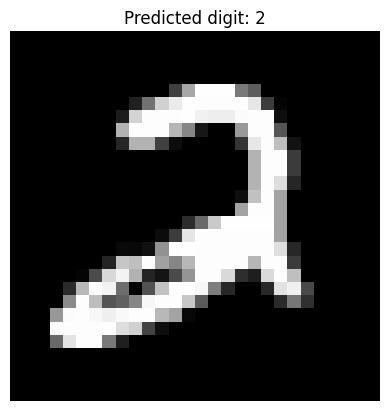

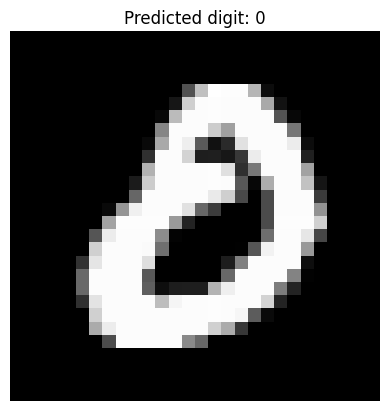

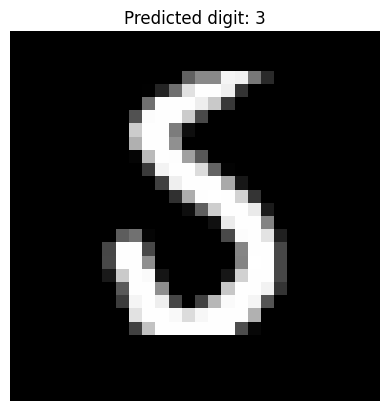

In [9]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit(test_dataset[index]['input'], get_digit(predicted_digit))

# 2. Classification on digits dataset using convolutional NN

## Function to get digits train/test data for CNN model

In [10]:
def get_digits_data_cnn():

    dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=10000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        dataset.append(
            {
                "input": torch.tensor([torch.tensor(input_values).reshape(28, 28).tolist()]),
                "output": torch.tensor(get_onehot_digit(int(train.loc[index]["label"]))),
            }
        )

    random.seed(123)
    random.shuffle(dataset)
    return dataset[:4000], dataset[4000:5000]

## Create convolutional NN model for classification on digits dataset and test

Epoch: 1/15, train loss: 0.9834, train Accuracy: 0.717, test loss: 0.3384, test Accuracy: 0.896, epoch time: 9.462s
Epoch: 2/15, train loss: 0.2737, train Accuracy: 0.911, test loss: 0.2465, test Accuracy: 0.926, epoch time: 9.008s
Epoch: 3/15, train loss: 0.1725, train Accuracy: 0.9463, test loss: 0.2153, test Accuracy: 0.942, epoch time: 9.257s
Epoch: 4/15, train loss: 0.1179, train Accuracy: 0.9617, test loss: 0.2489, test Accuracy: 0.921, epoch time: 9.321s
Epoch: 5/15, train loss: 0.0816, train Accuracy: 0.9745, test loss: 0.2402, test Accuracy: 0.934, epoch time: 8.975s
Epoch: 6/15, train loss: 0.0634, train Accuracy: 0.9772, test loss: 0.2025, test Accuracy: 0.948, epoch time: 9.603s
Epoch: 7/15, train loss: 0.0464, train Accuracy: 0.9842, test loss: 0.1807, test Accuracy: 0.96, epoch time: 9.463s
Epoch: 8/15, train loss: 0.032, train Accuracy: 0.9892, test loss: 0.2235, test Accuracy: 0.942, epoch time: 9.379s
Epoch: 9/15, train loss: 0.0237, train Accuracy: 0.9925, test loss: 

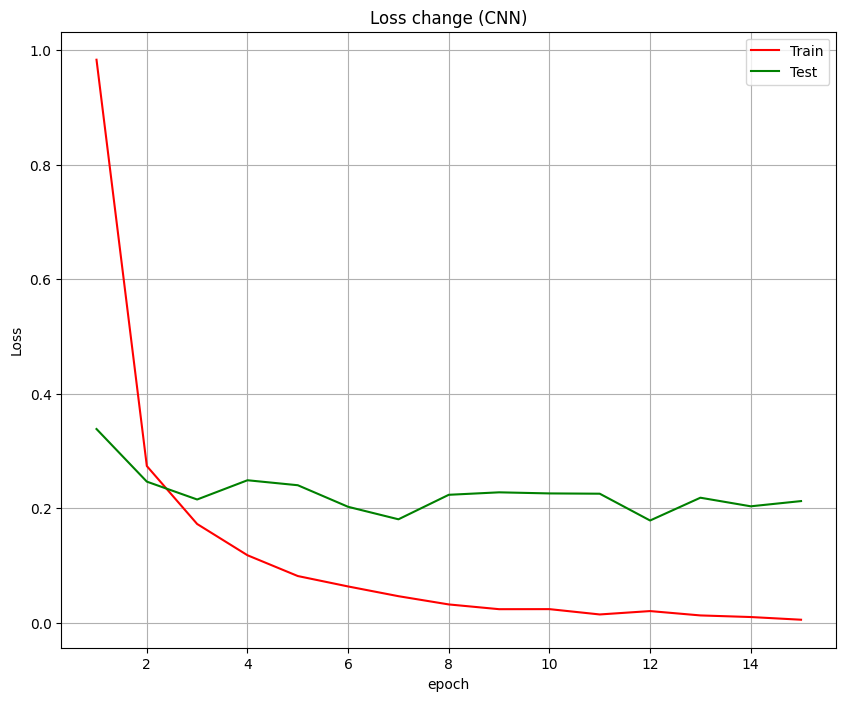

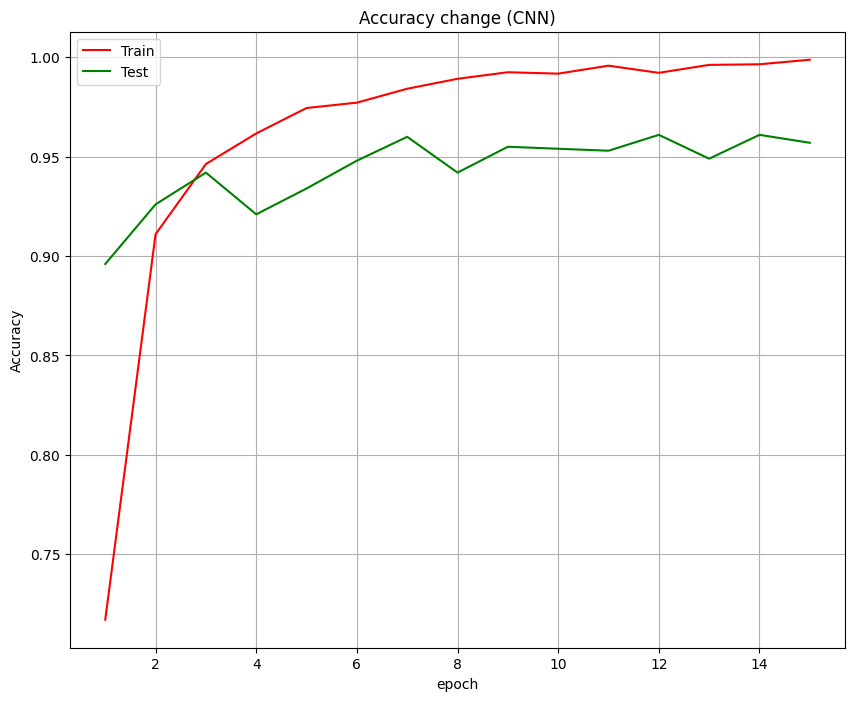

In [11]:
train_data, test_data = get_digits_data_cnn()

layers = [
    Convolutional(LeakyRelu(), filters_num=4, kernel_size=3, padding_type="same"),    
    MaxPool2D(),
    Convolutional(LeakyRelu(), filters_num=8, kernel_size=3, padding_type="same"),
    MaxPool2D(),
    Flatten(),
    FullyConnected(64, LeakyRelu()),
    FullyConnected(10, Linear()),
]
cnn = NeuralNetwork(
    Input3D((1, 28, 28)),
    layers,
    optimizer=Adam(learning_rate=0.0005),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction='argmax',
    use_gpu=True
)

start_time = time.time()

epochs = 15
history = cnn.fit(train_data, test_data, epochs=epochs, batch_size=2, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = cnn.predict(test_data)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change (CNN)")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change (CNN)")

## First ten test digits with predicted values (CNN)

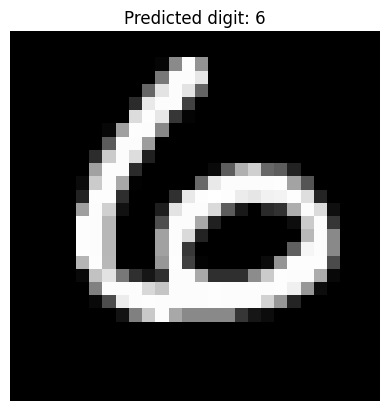

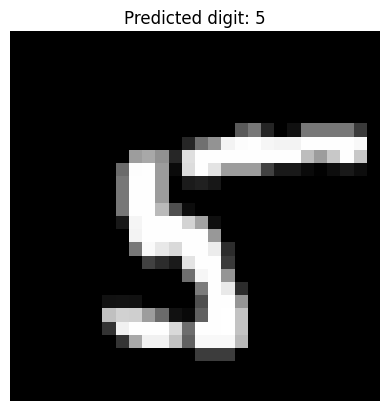

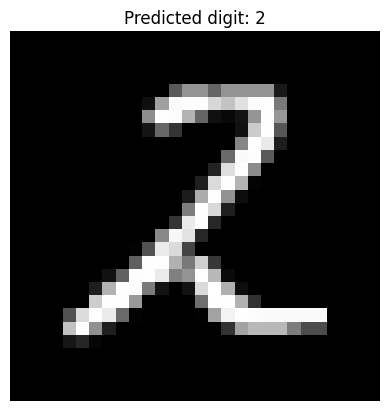

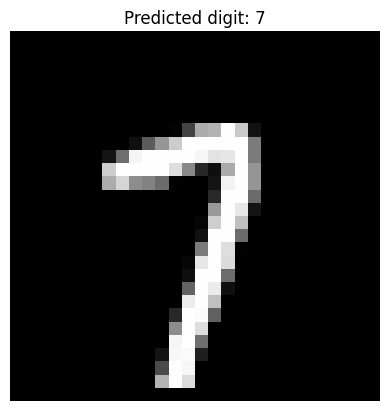

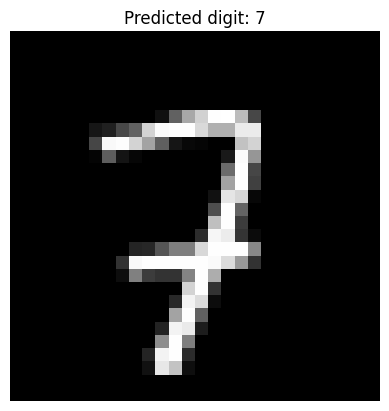

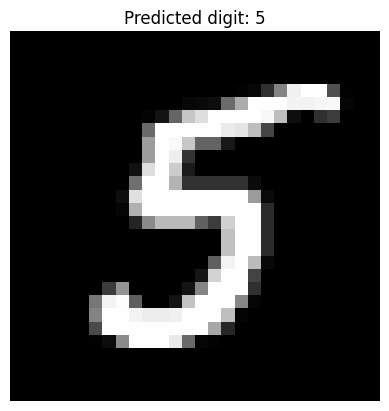

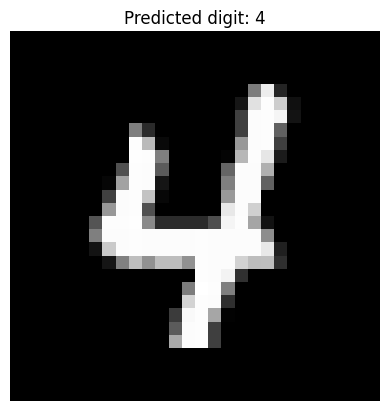

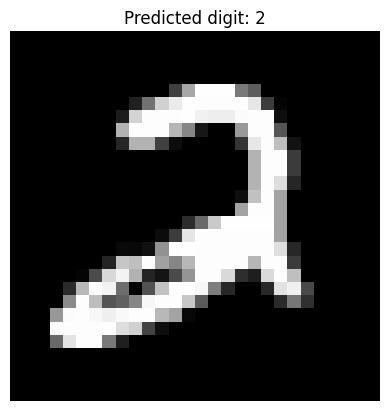

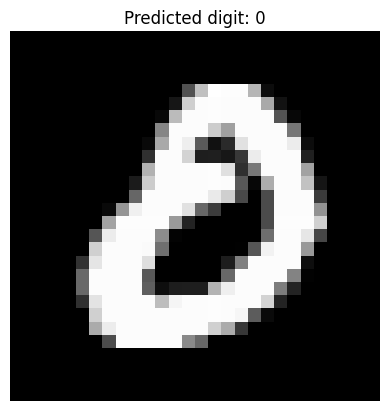

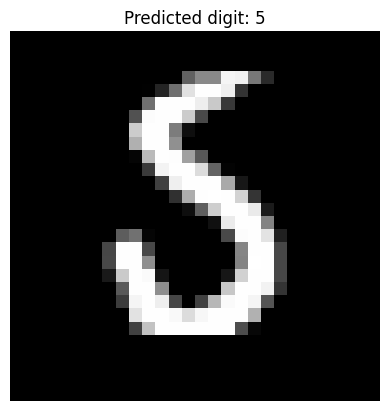

In [12]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit_cnn(test_data[index]['input'][0], get_digit(predicted_digit))